In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from blend_calc import *
from scipy.interpolate import interp1d
from neff_extrapolation import *


mpl.rc('font', family='serif', serif = "cmr10", size=18)
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams['axes.unicode_minus'] = False
DIRECTORY = '/mnt/44868D0F868D02A2/Users/veome/Google Drive/Academics/Senior Thesis/Code/Catalog/'

# Catalog Setup

In [2]:
# cosmos = np.genfromtxt(DIRECTORY+'acs_cosmos1361.gcat_ascii', usecols=range(0,10), invalid_raise=False)
cosmos = np.genfromtxt('superbit_cosmos1361_shape_abmag26.gcat_ascii', usecols=range(0,14), invalid_raise=False)


print("Original Catalog Size: %i"%cosmos.shape[0])

#  Redshift > 0 Cut
cosmos = cosmos[cosmos[:,2]>0] #cut is already in generate_catalog.py
print("New Catalog Size: %i"%cosmos.shape[0])


Original Catalog Size: 389181
New Catalog Size: 389181


In [3]:
MAG_LIM = 26.0 # Upper limit of the mag data in catalog. Data will be extrapolated after this point.
MAG_MIN = 21.0
MAG_MAX = MAG_LIM

# Mags vs Redshift Distribution

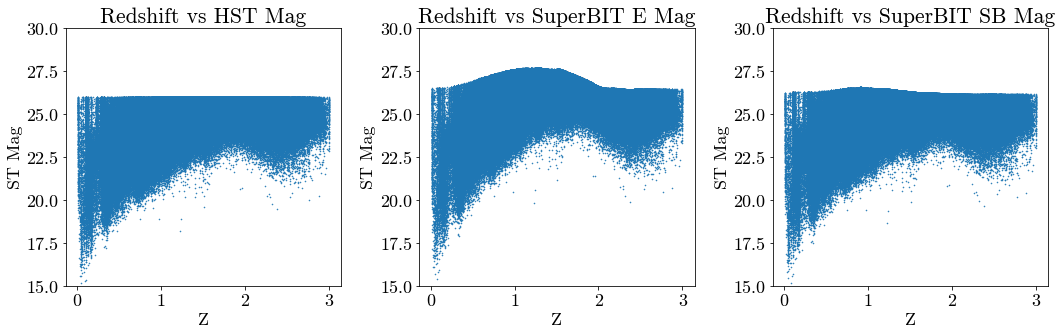

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.scatter(cosmos[:,2], cosmos[:,5], label="HST Mags", s=0.3)
ax1.set_title('Redshift vs HST Mag')
ax1.set_ylim([15.0, 30.0])

ax2.scatter(cosmos[:,2], cosmos[:,11], label="SuperBIT E Mags", s=0.3)
ax2.set_title('Redshift vs SuperBIT E Mag')
ax2.set_ylim([15.0, 30.0])

ax3.scatter(cosmos[:,2], cosmos[:,12], label="SuperBIT SB Mags", s=0.3)
ax3.set_title('Redshift vs SuperBIT SB Mag')
ax3.set_ylim([15.0, 30.0])

for ax in (ax1, ax2, ax3):
    ax.set(xlabel='Z', ylabel='ST Mag')

fig.tight_layout()
# plt.savefig(DIRECTORY+'all_mags.png')

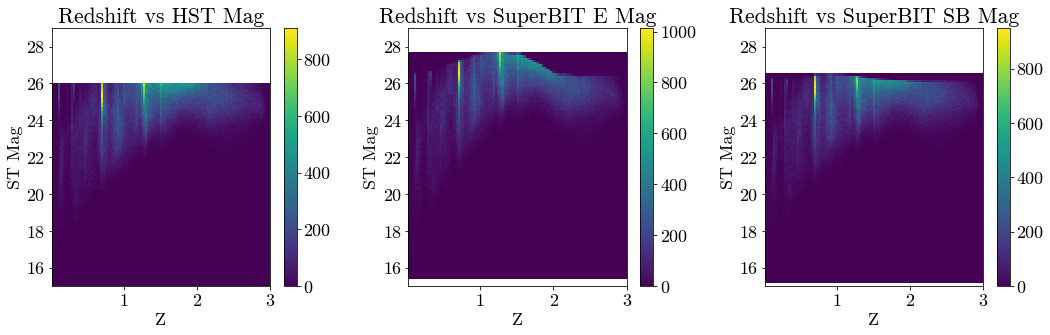

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

counts, xedges, yedges, im1 = ax1.hist2d(cosmos[:,2], cosmos[:,5], bins=100, label="HST Mags")
ax1.set_title('Redshift vs HST Mag')
ax1.set_ylim([15.0, MAG_LIM+3])

counts, xedges, yedges, im2 = ax2.hist2d(cosmos[:,2], cosmos[:,11], bins=100, label="SuperBIT E Mags")
ax2.set_title('Redshift vs SuperBIT E Mag')
ax2.set_ylim([15.0, MAG_LIM+3])

counts, xedges, yedges, im3 = ax3.hist2d(cosmos[:,2], cosmos[:,12], bins=100, label="SuperBIT SB Mags")
ax3.set_title('Redshift vs SuperBIT SB Mag')
ax3.set_ylim([15.0, MAG_LIM+3])

ax = [ax1, ax2, ax3]
im = [im1, im2, im3]

for i in range(3):
    ax[i].set(xlabel='Z', ylabel='ST Mag')  
    fig.colorbar(im[i], ax=ax[i])


fig.tight_layout()
# plt.savefig(DIRECTORY+'all_mags.png')

# FWHM Calculation (For Blending)

$ \mathrm{FWHM} \approx 2.355 \sigma $

Minimum Separation for Resolution = $1.22 \frac{\lambda}{D} \approx  \mathrm{ FWHM}$

For the Shape Band in SuperBIT, $\lambda = 680 \times 10^{-9} \mathrm{m}$

$$\theta_d \approx 1.22 \frac{\lambda}{0.5 \mathrm{m}}\approx 0.342 "$$

$$\theta_{\text{res}} = \sqrt{\theta_d^2 + \theta_{\text{jitter}}^2} \approx 0.362 "$$



For F814W Band in SuperBIT, $\lambda = 814 \times 10^{-9} \mathrm{m}$

$$\theta_d \approx 1.22 \frac{\lambda}{0.5 \mathrm{m}}\approx 0.410 "$$

$$\theta_{\text{res}} = \sqrt{\theta_d^2 + \theta_{\text{jitter}}^2} \approx 0.426 "$$

In [6]:
# Calculate SuperBIT PSF
lam = 680 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT PSF: %.3f\"" %SUPERBIT_PSF)

# Calculate SuperBIT PSF for f814W Mags
lam = 814 * u.nm
theta = 1.22 * lam  * u.rad / (0.5*u.m) # in radians
theta = theta.to(u.arcsec) # in arcsec to combine with jitter
jitter = 0.118 * u.arcsec

psf = np.sqrt(jitter**2 + theta**2)
SUPERBIT_F814W_PSF = psf.to(u.arcsec).value # in arcsec
print("SuperBIT F814W PSF: %.3f\"" %SUPERBIT_F814W_PSF)

PIX_TO_ARCSEC = 0.05 # arcsec per HST ACS pixel (Koekemoer et. al. 2007)
ARCSEC_TO_PIX = 1/PIX_TO_ARCSEC # HST ACS pixel per arcsec

SuperBIT PSF: 0.362"
SuperBIT F814W PSF: 0.426"


In [7]:
#  Size > 1.2*PSF Cut
cosmos_sb_f814w = cosmos[cosmos[:,9]>=1.2*SUPERBIT_F814W_PSF*ARCSEC_TO_PIX]
print("SuperBIT F814W Catalog Size: %i"%cosmos_sb_f814w.shape[0])

cosmos_sb = cosmos[cosmos[:,9]>=1.2*SUPERBIT_PSF*ARCSEC_TO_PIX]
print("SuperBIT Shape Catalog Size: %i"%cosmos_sb.shape[0])

SuperBIT F814W Catalog Size: 336672
SuperBIT Shape Catalog Size: 359743


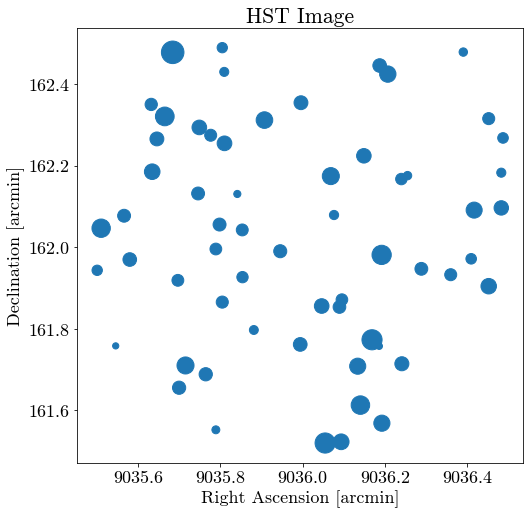

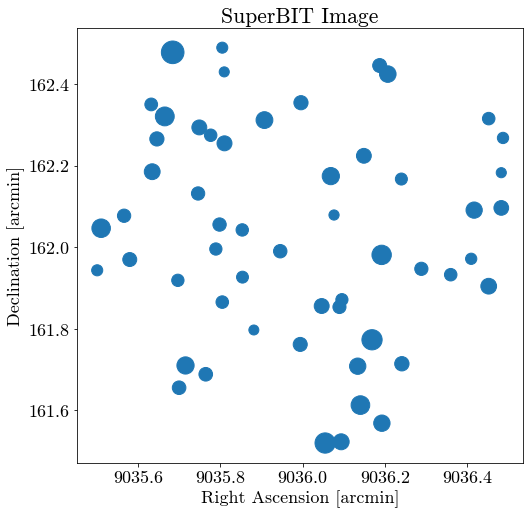

In [8]:
# Sanity check for get_cat_subset
center = [150.6, 2.7]
test_hst = get_cat_subset(cosmos, center)
test_hst[:,9] = test_hst[:,9]*PIX_TO_ARCSEC

test_sb = get_cat_subset(cosmos_sb, center)
test_sb[:,9] = test_sb[:,9]*PIX_TO_ARCSEC

psf = SUPERBIT_PSF
sizes_sb = np.sqrt(test_sb[:,9]**2 + psf**2)
sizes_sb

plt.figure(figsize=(8,8))
plt.scatter(test_hst[:,0]*u.deg.to(u.arcmin),(test_hst[:,1]*u.deg).to(u.arcmin), s=(10000*test_hst[:,9]*u.arcsec.to(u.arcmin)))
plt.title("HST Image")
plt.xlabel("Right Ascension [arcmin]")
plt.ylabel("Declination [arcmin]")
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(test_sb[:,0]*u.deg.to(u.arcmin),(test_sb[:,1]*u.deg).to(u.arcmin), s=(10000*sizes_sb*u.arcsec.to(u.arcmin)))
plt.title("SuperBIT Image")
plt.xlabel("Right Ascension [arcmin]")
plt.ylabel("Declination [arcmin]")
plt.show()


# Total Objects vs ST Mag

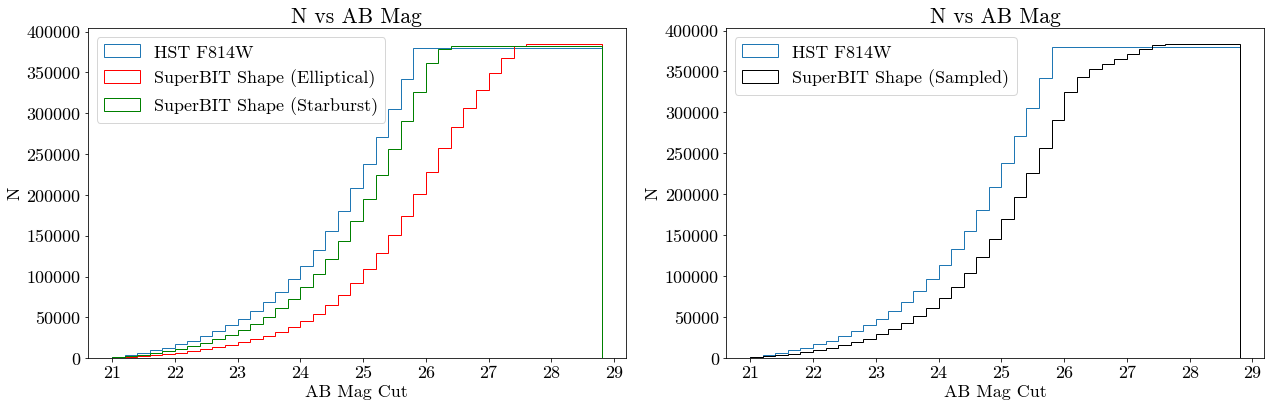

In [9]:
bins = mags = np.arange(21, 29, 0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.hist(cosmos[:,5], bins=bins, cumulative=True, label='HST F814W', histtype='step', color='C0')
ax1.hist(cosmos[:,11], bins=bins, cumulative=True, label='SuperBIT Shape (Elliptical)', histtype='step', color='r')
ax1.hist(cosmos[:,12], bins=bins, cumulative=True, label='SuperBIT Shape (Starburst)', histtype='step', color='g')
ax1.set_title("N vs AB Mag")
ax1.legend(loc='upper left')
ax1.set(xlabel="AB Mag Cut", ylabel='N')

ax2.hist(cosmos[:,5], bins=bins, cumulative=True, label='HST F814W', histtype='step', color='C0')
ax2.hist(cosmos[:,13], bins=bins, cumulative=True, label='SuperBIT Shape (Sampled)', histtype='step', color='k')
ax2.set_title("N vs AB Mag")
ax2.legend(loc='upper left')


for ax in (ax1, ax2):
    ax.set(xlabel="AB Mag Cut", ylabel='N')

fig.tight_layout()
# plt.savefig(DIRECTORY+'mag_conversion_total_mixed.png', bbox_inches='tight')

Text(0, 0.5, 'N')

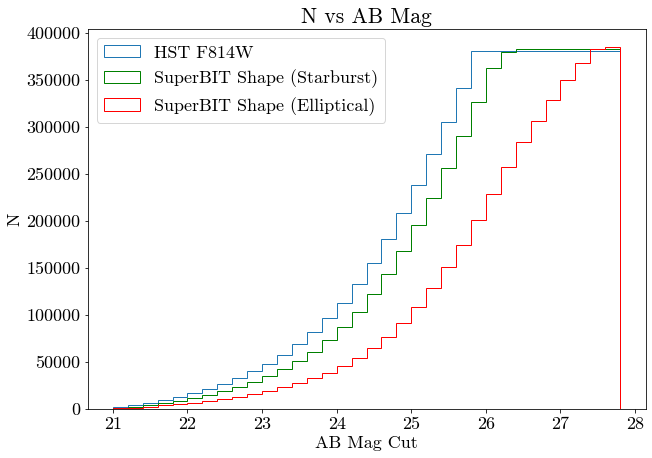

In [10]:
bins = mags = np.arange(21, 28, 0.2)
plt.figure(figsize=(10,7))
plt.hist(cosmos[:,5], bins=bins, cumulative=True, label='HST F814W', histtype='step', color='C0')
plt.hist(cosmos[:,12], bins=bins, cumulative=True, label='SuperBIT Shape (Starburst)', histtype='step', color='g')
plt.hist(cosmos[:,11], bins=bins, cumulative=True, label='SuperBIT Shape (Elliptical)', histtype='step', color='r')
plt.title("N vs AB Mag")
plt.legend(loc='upper left')
plt.xlabel("AB Mag Cut")
plt.ylabel('N')

# plt.savefig(DIRECTORY+'mag_conversion_total_split.png', bbox_inches='tight')

Text(0, 0.5, 'N')

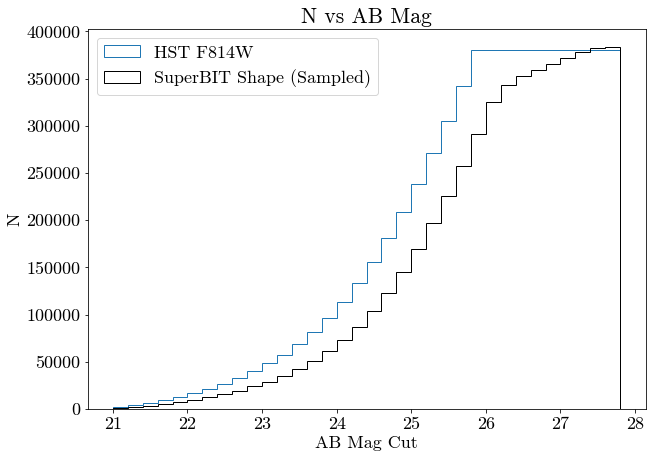

In [11]:
bins = mags = np.arange(21, 28, 0.2)
plt.figure(figsize=(10,7))
plt.hist(cosmos[:,5], bins=bins, cumulative=True, label='HST F814W', histtype='step', color='C0')
plt.hist(cosmos[:,13], bins=bins, cumulative=True, label='SuperBIT Shape (Sampled)', histtype='step', color='k')
plt.title("N vs AB Mag")
plt.legend(loc='upper left')
plt.xlabel("AB Mag Cut")
plt.ylabel('N')
# plt.savefig(DIRECTORY+'mag_conversion_total_sampled.png', bbox_inches='tight')

In [12]:
# HST neff vs Magnitude
hst_mag_neff = [[], [], [], [], [], [],
                [], [], [], [], [], [],
                [], [], [], [], [], []]

mags = np.linspace(21.0, MAG_LIM, num=len(hst_mag_neff))
    
for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(hst_mag_neff)):
            hst_mag_neff[i].append(get_cat_subset(cosmos,[ra,dec],magcut=mags[i]).shape[0])

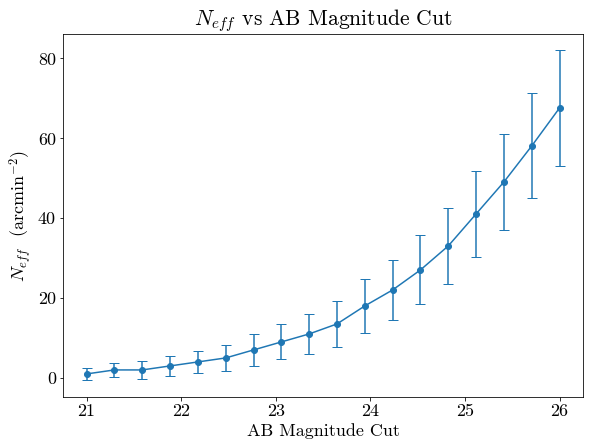

In [13]:
hst_meds = []
hst_stds = []
for i in range (len(hst_mag_neff)):
    hst_meds.append(np.nanmedian(hst_mag_neff[i]))
    hst_stds.append(np.nanstd(hst_mag_neff[i]))


# Plot n_eff
plt.figure(figsize=(8,6))

plt.errorbar(mags, hst_meds, yerr=hst_stds,fmt='-o', color='C0')

plt.title("$N_{eff}$ vs AB Magnitude Cut")
plt.xlabel("AB Magnitude Cut")
plt.ylabel('$N_{eff}$  (arcmin$^{-2}$)')
plt.tight_layout(pad=0)


# plt.savefig(DIRECTORY+'neff_hst_mag_raw.png', bbox_inches='tight')
plt.show()

# Magnitude Adjustments Only

In [14]:
# SuperBIT neff vs E Magnitude (no blending)
sbit_e_mag_neff = [[], [], [], [], [], [],
                [], [], [], [], [], [],
                [], [], [], [], [], []]

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(sbit_e_mag_neff)):
            sbit_e_mag_neff[i].append(get_cat_subset(cosmos,[ra,dec],super_e_mag=mags[i]).shape[0])

In [15]:
# SuperBIT neff vs Starburst Magnitude (no blending)
sbit_sb_mag_neff = [[], [], [], [], [], [],
                [], [], [], [], [], [],
                [], [], [], [], [], []]

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(sbit_sb_mag_neff)):
            sbit_sb_mag_neff[i].append(get_cat_subset(cosmos,[ra,dec],super_sb_mag=mags[i]).shape[0])

In [16]:
# SuperBIT neff vs Sampled SED Magnitude (no blending)
sbit_mixed_mag_neff = [[], [], [], [], [], [],
                [], [], [], [], [], [],
                [], [], [], [], [], []]

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(sbit_sb_mag_neff)):
            sbit_mixed_mag_neff[i].append(get_cat_subset(cosmos,[ra,dec],super_mixed_mag=mags[i]).shape[0])

In [17]:
# Plot Neff vs Magnitude (No Blending)

mags = np.linspace(MAG_MIN, MAG_MAX, num=len(hst_mag_neff)) # Range of data

# Calculate median values for each magnitude
e_meds = []
e_stds = []
for i in range (len(sbit_e_mag_neff)):
    e_meds.append(np.nanmedian(sbit_e_mag_neff[i]))
    e_stds.append(np.nanstd(sbit_e_mag_neff[i]))
    
sb_meds = []
sb_stds = []
for i in range (len(sbit_sb_mag_neff)):
    sb_meds.append(np.nanmedian(sbit_sb_mag_neff[i]))
    sb_stds.append(np.nanstd(sbit_sb_mag_neff[i]))
    
mixed_meds = []
mixed_stds = []
for i in range (len(sbit_mixed_mag_neff)):
    mixed_meds.append(np.nanmedian(sbit_mixed_mag_neff[i]))
    mixed_stds.append(np.nanstd(sbit_mixed_mag_neff[i]))
    

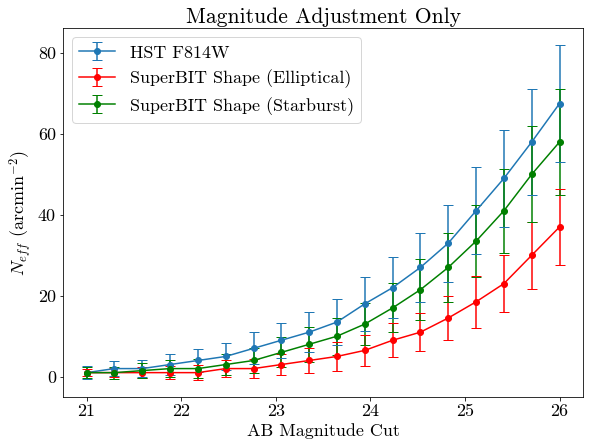

In [18]:
# Extrapolation range
plt_mags= np.linspace(21.0, MAG_LIM + 3, num=len(hst_mag_neff)) 


# Plot n_eff
plt.figure(figsize=(8,6))

plt.errorbar(mags, hst_meds, yerr=hst_stds,fmt='-o', label="HST F814W", color='C0')

plt.errorbar(mags, e_meds, yerr=e_stds,fmt='-o', label="SuperBIT Shape (Elliptical)", color='r')

plt.errorbar(mags, sb_meds, yerr=sb_stds,fmt='-o', label="SuperBIT Shape (Starburst)", color='g')

# plt.errorbar(mags, mixed_meds, yerr=mixed_stds,fmt='-o', label="SuperBIT Shape (Sampled)", color='k')


plt.title("Magnitude Adjustment Only")
plt.xlabel("AB Magnitude Cut")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
# plt.grid(linestyle='--')


plt.savefig(DIRECTORY+'neff_mag_only_split_raw.png', bbox_inches='tight')
plt.show()

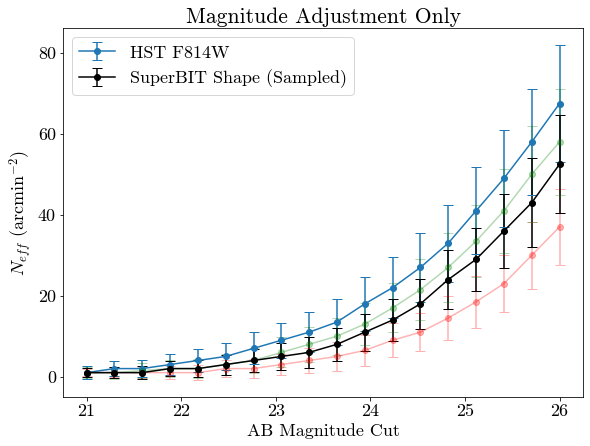

In [19]:
# Extrapolation range
plt_mags= np.linspace(21.0, MAG_LIM + 3, num=len(hst_mag_neff)) 
a1 = 0.3

# Plot n_eff
plt.figure(figsize=(8,6))

plt.errorbar(mags, hst_meds, yerr=hst_stds,fmt='-o', label="HST F814W", color='C0')

plt.errorbar(mags, e_meds, yerr=e_stds,fmt='-o', color='r', alpha = a1)

plt.errorbar(mags, sb_meds, yerr=sb_stds,fmt='-o', color='g', alpha = a1)

plt.errorbar(mags, mixed_meds, yerr=mixed_stds,fmt='-o', label="SuperBIT Shape (Sampled)", color='k')


plt.title("Magnitude Adjustment Only")
plt.xlabel("AB Magnitude Cut")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
# plt.grid(linestyle='--')


# plt.savefig(DIRECTORY+'neff_mag_only_mixed_raw.png', bbox_inches='tight')
plt.show()

## Best Fit + Extrapolation

$$N_{\text{eff}}(mag) = N_0 \cdot a^{mag} \int_0^{mag} f(mag') \text{ d } mag'$$

In [20]:
# Extrapolate N_eff using form N_eff = N_0 * a**mag * integral

x = np.linspace(MAG_MIN, MAG_MAX, num=len(hst_mag_neff))

# HST
f_hst = get_n_mag(MAG_MIN, MAG_MAX, 0.2, 0, cosmos) # Fraction Function
hst_fit, covar = get_n_fit(x, hst_meds, f_hst) # Best Fit Parameters

# SuperBIT
f_superbit = get_n_mag(MAG_MIN, MAG_MAX, 0.2, SUPERBIT_PSF, cosmos) # Fraction Function
e_fit, covar = get_n_fit(x, e_meds, f_superbit) # Best Fit Parameters
sb_lim = 0
sb_fit, covar = get_n_fit(x[:len(x)-sb_lim], sb_meds[:len(sb_meds)-sb_lim], f_superbit) # Best Fit Parameters
mixed_fit, covar = get_n_fit(x, mixed_meds, f_superbit) # Best Fit Parameters


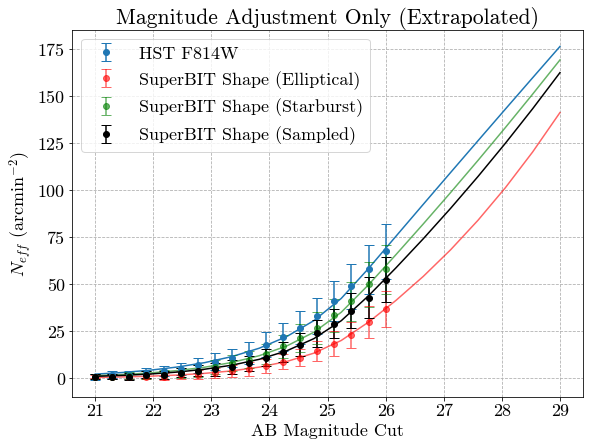

In [21]:
# Extrapolation range
plt_mags= np.linspace(21.0, MAG_LIM + 3, num=len(hst_mag_neff)) 
a1 = 0.6

# Plot n_eff
plt.figure(figsize=(8,6))

plt.plot(plt_mags, n_extrapolation(plt_mags, *hst_fit, f_hst),color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds,fmt='o', label="HST F814W", color='C0')

plt.plot(plt_mags, n_extrapolation(plt_mags, *e_fit, f_superbit), color='r', alpha = a1)
plt.errorbar(mags, e_meds, yerr=e_stds,fmt='o', label="SuperBIT Shape (Elliptical)", color='r', alpha = a1)


plt.plot(plt_mags, n_extrapolation(plt_mags, *sb_fit, f_superbit), color='g', alpha = a1)
plt.errorbar(mags[:len(mags)-sb_lim], sb_meds[:len(sb_meds)-sb_lim], yerr=sb_stds[:len(sb_stds)-sb_lim],fmt='o', label="SuperBIT Shape (Starburst)", color='g', alpha = a1)

plt.plot(plt_mags, n_extrapolation(plt_mags, *mixed_fit, f_superbit), color='k')
plt.errorbar(mags, mixed_meds, yerr=mixed_stds,fmt='o', label="SuperBIT Shape (Sampled)", color='k')

plt.title("Magnitude Adjustment Only (Extrapolated)")
plt.xlabel("AB Magnitude Cut")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
plt.grid(linestyle='--')


# plt.savefig(DIRECTORY+'neff_mag_extrapolation.png', bbox_inches='tight')
plt.show()

# Redshift Investigation

## HST

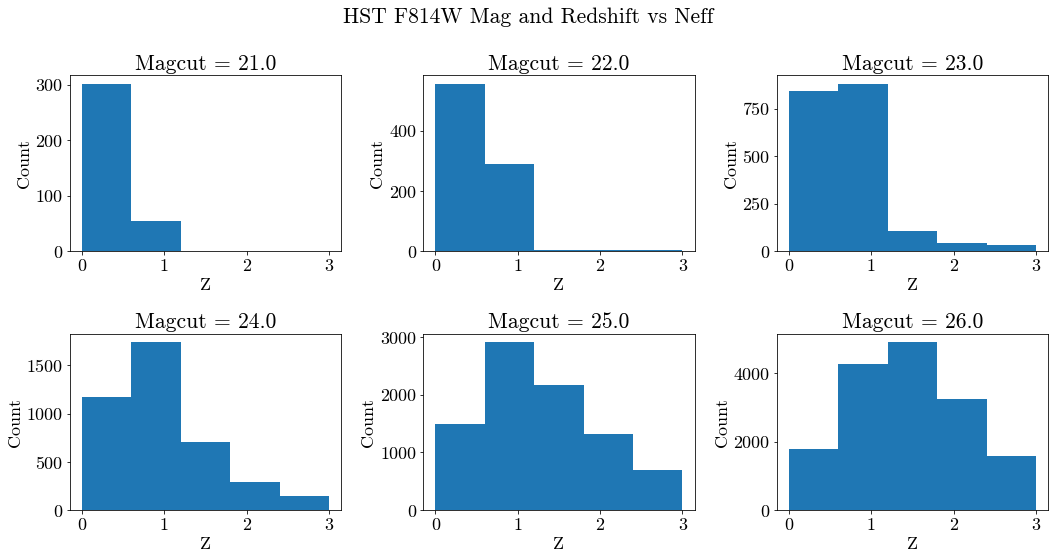

In [22]:
# HST N vs F814W Magnitude AND Redshift
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8))
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

z_mags = np.linspace(21.0, MAG_LIM, num=len(ax))
zs = np.linspace(0.0, 3.0, num=len(ax))
size = 8

for i in range(len(z_mags)):
    cat = get_cat_subset(cosmos, [150.0,2.0], ra_range=size*u.arcmin, dec_range=size*u.arcmin, magcut=z_mags[i])
    ax[i].hist(cat[:,2], bins=zs)
    ax[i].set_title('Magcut = {}'.format(z_mags[i]))
    ax[i].set(xlabel='Z', ylabel='Count') 

fig.suptitle('HST F814W Mag and Redshift vs Neff')
fig.tight_layout()


## SuperBIT Elliptical

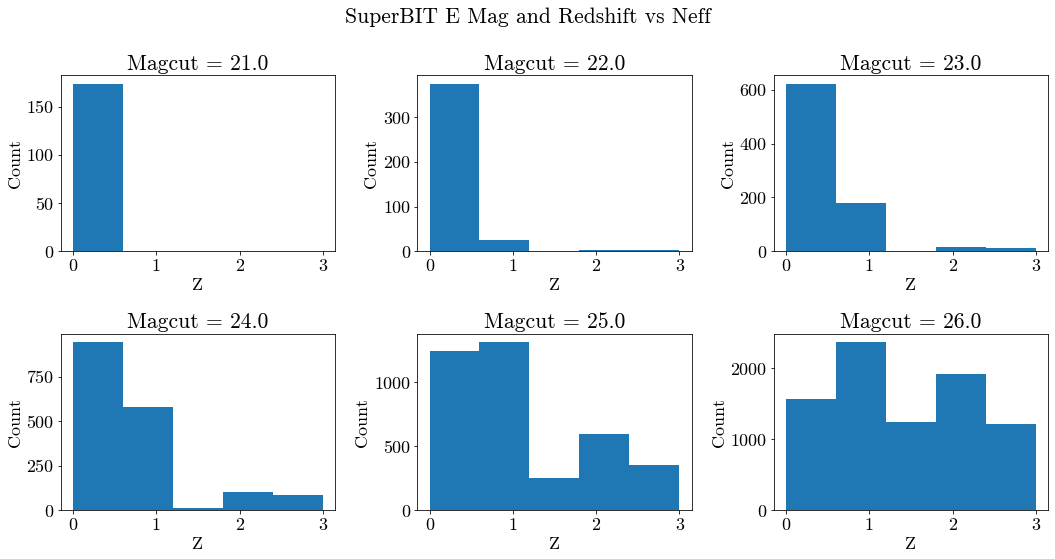

In [23]:
# SuperBIT N vs E Magnitude AND Redshift
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8))
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

z_mags = np.linspace(21.0, MAG_LIM, num=len(ax))
zs = np.linspace(0.0, 3.0, num=len(ax))
size = 8

for i in range(len(z_mags)):
    cat = get_cat_subset(cosmos, [150.0,2.0], ra_range=size*u.arcmin, dec_range=size*u.arcmin, super_e_mag=z_mags[i])
    ax[i].hist(cat[:,2], bins=zs)
    ax[i].set_title('Magcut = {}'.format(z_mags[i]))
    ax[i].set(xlabel='Z', ylabel='Count') 

fig.suptitle('SuperBIT E Mag and Redshift vs Neff')
fig.tight_layout()


## SuperBIT Starburst

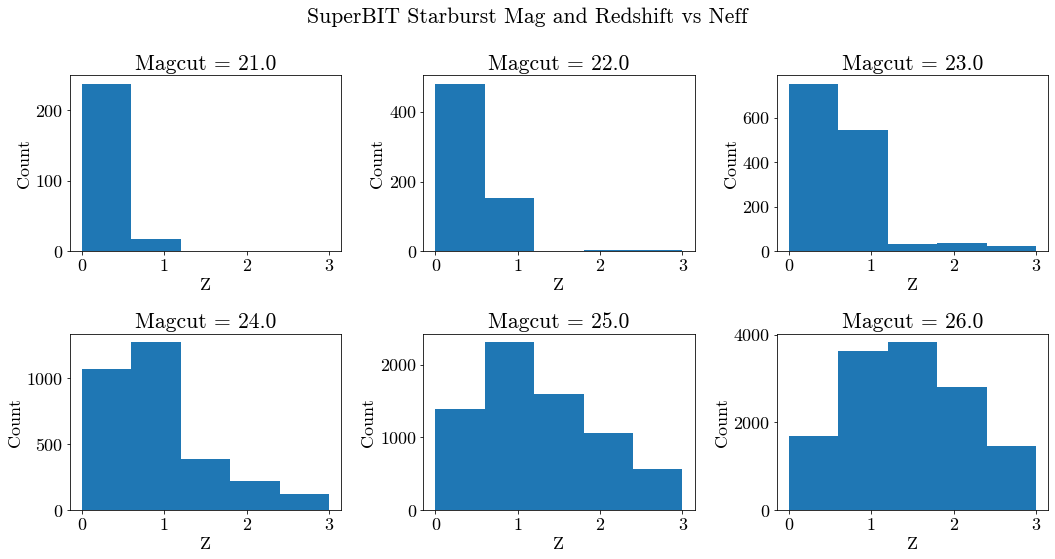

In [24]:
# SuperBIT N vs Starburst Magnitude AND Redshift
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8))
ax = [ax1, ax2, ax3, ax4, ax5, ax6]

z_mags = np.linspace(21.0, MAG_LIM, num=len(ax))
zs = np.linspace(0.0, 3.0, num=len(ax))
size = 8

for i in range(len(z_mags)):
    cat = get_cat_subset(cosmos, [150.0,2.0], ra_range=size*u.arcmin, dec_range=size*u.arcmin, super_sb_mag=z_mags[i])
    ax[i].hist(cat[:,2], bins=zs)
    ax[i].set_title('Magcut = {}'.format(z_mags[i]))
    ax[i].set(xlabel='Z', ylabel='Count') 

fig.suptitle('SuperBIT Starburst Mag and Redshift vs Neff')
fig.tight_layout()


# Blending Effect Only

Maybe I can show multiple PSFs (like ground-based) to compare blending effects.

In [25]:
# Blending vs Magnitude (for F814W Mags)
f814w_blend_mag = [[], [], [], [], [], [],
                   [], [], [], [], [], [],
                   [], [], [], [], [], []]

mags = np.linspace(21.0, MAG_LIM, num=len(f814w_blend_mag))

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(f814w_blend_mag)):
            f814w_blend_mag[i].append(get_blend_ratio(cosmos, [ra, dec], SUPERBIT_F814W_PSF, mag=mags[i]))


In [26]:
mags = np.linspace(21.0, MAG_LIM, num=len(f814w_blend_mag))

# HST (F814W) vs SuperBIT (F814W)
hst_meds = np.empty(len(f814w_blend_mag))
hst_stds = np.empty(len(f814w_blend_mag))

for i in range (len(hst_mag_neff)):
    hst_meds[i]= np.nanmedian(hst_mag_neff[i])
    hst_stds[i]= np.nanstd(hst_mag_neff[i])

med_blend = np.empty(len(f814w_blend_mag))
std_blend = np.empty(len(f814w_blend_mag))

for i in range(len(f814w_blend_mag)):
    med_blend[i] = np.nanmean(f814w_blend_mag[i])
    std_blend[i]= np.nanstd(hst_mag_neff[i])


sbit_meds = hst_meds - (med_blend*hst_meds)

sbit_stds = std_blend

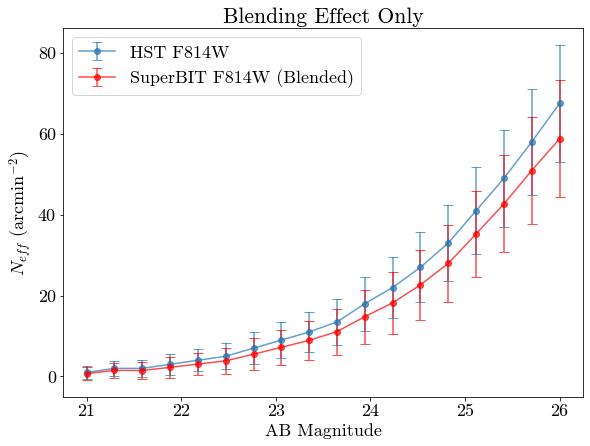

In [27]:
plt_mags= np.linspace(21.0, MAG_LIM+3, num=len(f814w_blend_mag)) # Extrapolation Range

# Plot n_eff
plt.figure(figsize=(8,6))
alp=0.7

# plt.plot(plt_mags, n_extrapolation(plt_mags, *hst_fit, f_hst), color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds, fmt='-o',  label="HST F814W", color='C0', alpha=alp)

# plt.plot(plt_mags, n_extrapolation(plt_mags, *sbit_fit, f_superbit_f814w), color='r')
plt.errorbar(mags, sbit_meds, yerr=sbit_stds, fmt='-o', color='r', label="SuperBIT F814W (Blended)", alpha=alp)

plt.title("Blending Effect Only")
plt.xlabel("AB Magnitude")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
# plt.grid(linestyle='--')
# plt.xlim(21, 26)
# plt.ylim(0, 100)

# plt.savefig(DIRECTORY+'blending_only_f814w_magnitude_neff_raw.png', bbox_inches='tight')

## Extrapolation

In [28]:
# Extrapolate N_eff using form N_eff = N_0 * a**mag * integral

x = np.linspace(MAG_MIN, MAG_MAX, num=len(hst_mag_neff))

# HST
f_hst = get_n_mag(MAG_MIN, MAG_MAX, 0.2, 0, cosmos) # Fraction Function
hst_fit, covar = get_n_fit(x, hst_meds, f_hst) # Best Fit Parameters

# SuperBIT
f_superbit_f814w = get_n_mag(MAG_MIN, MAG_MAX, 0.2, SUPERBIT_F814W_PSF, cosmos) # Extrapolation Function
sbit_fit, covar = get_n_fit(x, sbit_meds, f_superbit_f814w) # Best Fit Parameters

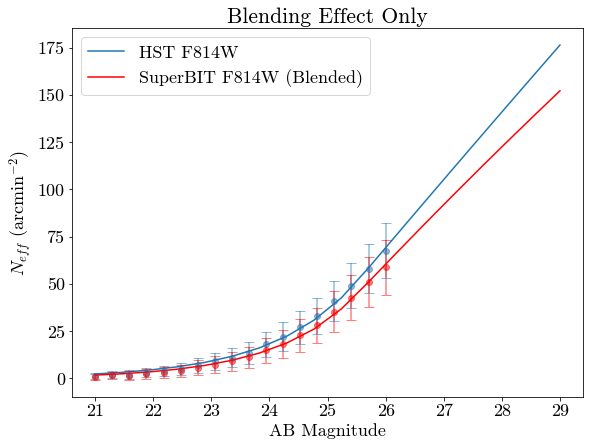

In [29]:
plt_mags= np.linspace(21.0, MAG_LIM+3, num=len(f814w_blend_mag)) # Extrapolation Range

# Plot n_eff
plt.figure(figsize=(8,6))
alp=0.5

plt.plot(plt_mags, n_extrapolation(plt_mags, *hst_fit, f_hst), label="HST F814W", color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds, fmt='o', color='C0', alpha=alp)

plt.plot(plt_mags, n_extrapolation(plt_mags, *sbit_fit, f_superbit_f814w), label="SuperBIT F814W (Blended)", color='r')
plt.errorbar(mags, sbit_meds, yerr=sbit_stds, fmt='o', color='r', alpha=alp)

plt.title("Blending Effect Only")
plt.xlabel("AB Magnitude")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
# plt.grid(linestyle='--')
# plt.xlim(21, 26)
# plt.ylim(0, 100)

# plt.savefig(DIRECTORY+'blending_only_f814w_magnitude_neff_extrapolated.png', bbox_inches='tight')

# Blending + Magnitude Adjustment

In [30]:
# Blending vs Elliptical Magnitude (for SuperBIT Mags)
superbit_e_blend_mag = [[], [], [], [], [], [],
                        [], [], [], [], [], [],
                        [], [], [], [], [], []]

mags = np.linspace(21.0, MAG_LIM, num=len(superbit_e_blend_mag))

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(superbit_e_blend_mag)):
            superbit_e_blend_mag[i].append(get_blend_ratio(cosmos, [ra, dec], SUPERBIT_PSF, super_e_mag=mags[i]))

In [31]:
# Blending vs Starburst Magnitude (for SuperBIT Mags)
superbit_sb_blend_mag = [[], [], [], [], [], [],
                         [], [], [], [], [], [],
                         [], [], [], [], [], []]

mags = np.linspace(21.0, MAG_LIM, num=len(superbit_sb_blend_mag))

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(superbit_sb_blend_mag)):
            superbit_sb_blend_mag[i].append(get_blend_ratio(cosmos, [ra, dec], SUPERBIT_PSF, super_sb_mag=mags[i]))

In [32]:
# Blending vs Mixed Magnitude (for SuperBIT Mags)
superbit_mixed_blend_mag = [[], [], [], [], [], [],
                        [], [], [], [], [], [],
                        [], [], [], [], [], []]

mags = np.linspace(21.0, MAG_LIM, num=len(superbit_mixed_blend_mag))

for ra in np.arange(149.6,150.6,0.1):
    for dec in np.arange(1.7,2.7,0.1):
        for i in range(len(superbit_mixed_blend_mag)):
            superbit_mixed_blend_mag[i].append(get_blend_ratio(cosmos, [ra, dec], SUPERBIT_PSF, super_mixed_mag=mags[i]))

## Raw Data

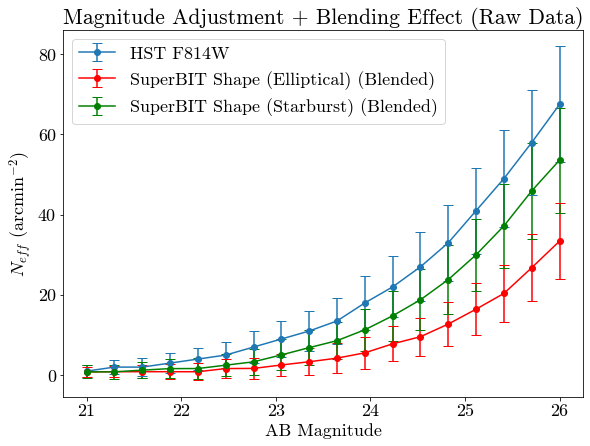

In [33]:
# Plot n_eff raw data

mags = np.linspace(21.0, MAG_LIM, num=len(superbit_e_blend_mag))

# HST (F814W) vs SuperBIT Neff
e_med_blend = np.empty(len(superbit_e_blend_mag))
e_std_blend = np.empty(len(superbit_e_blend_mag))

sb_med_blend = np.empty(len(superbit_sb_blend_mag))
sb_std_blend = np.empty(len(superbit_sb_blend_mag))

mixed_med_blend = np.empty(len(superbit_mixed_blend_mag))
mixed_std_blend = np.empty(len(superbit_mixed_blend_mag))


for i in range (len(superbit_e_blend_mag)):
    e_med_blend[i] = np.nanmean(superbit_e_blend_mag[i])
    e_std_blend[i]= np.nanstd(superbit_e_blend_mag[i])

    sb_med_blend[i] = np.nanmean(superbit_sb_blend_mag[i])
    sb_std_blend[i]= np.nanstd(superbit_sb_blend_mag[i])
    
    mixed_med_blend[i] = np.nanmean(superbit_mixed_blend_mag[i])
    mixed_std_blend[i]= np.nanstd(superbit_mixed_blend_mag[i])

# Subtract blended objects from Shape Band Neff
sbit_e_meds = e_meds - (e_med_blend*e_meds)
sbit_e_stds = e_std_blend + e_stds

sbit_sb_meds = sb_meds - (sb_med_blend*sb_meds)
sbit_sb_stds = sb_std_blend + sb_stds

sbit_mixed_meds = mixed_meds - (mixed_med_blend*mixed_meds)
sbit_mixed_stds = mixed_std_blend + mixed_stds


plt.figure(figsize=(8,6))
alp=1

# Plot HST F814W N_effs
plt.errorbar(mags, hst_meds, yerr=hst_stds, label="HST F814W", fmt='-o', color='C0', alpha=alp)
# plt.errorbar(mags, sbit_meds, yerr=sbit_stds, label="SuperBIT F814W (Blended)", fmt='-o', color='b', alpha=alp)

# Plot SuperBIT Shape N_effs
plt.errorbar(mags, sbit_e_meds, yerr=sbit_e_stds, label="SuperBIT Shape (Elliptical) (Blended)", fmt='-o', color='r', alpha=alp)
plt.errorbar(mags, sbit_sb_meds, yerr=sbit_sb_stds, label="SuperBIT Shape (Starburst) (Blended)", fmt='-o', color='g', alpha=alp)
# plt.errorbar(mags, sbit_mixed_meds, yerr=sbit_mixed_stds, label="SuperBIT Shape (Sampled) (Blended)", fmt='-o', color='k', alpha=alp)


plt.title("Magnitude Adjustment + Blending Effect (Raw Data)")
plt.xlabel("AB Magnitude")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
# plt.grid(linestyle='--')

# plt.xlim(21.1, 29)
# plt.ylim(37.5, 38.5)

# plt.savefig(DIRECTORY+'blending+magnitude_neff_split_raw.png', bbox_inches='tight')

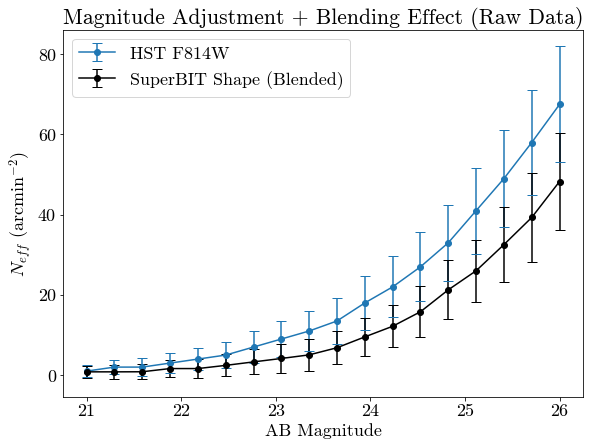

In [34]:
plt.figure(figsize=(8,6))
alp=1
a1=0.0
# Plot HST F814W N_effs
plt.errorbar(mags, hst_meds, yerr=hst_stds, label="HST F814W", fmt='-o', color='C0', alpha=alp)
# plt.errorbar(mags, sbit_meds, yerr=sbit_stds, label="SuperBIT F814W (Blended)", fmt='-o', color='r', alpha=alp)

# Plot SuperBIT Shape N_effs
plt.errorbar(mags, sbit_e_meds, yerr=sbit_e_stds, fmt='-o', color='r', alpha=a1)
plt.errorbar(mags, sbit_sb_meds, yerr=sbit_sb_stds, fmt='-o', color='g', alpha=a1)
plt.errorbar(mags, sbit_mixed_meds, yerr=sbit_mixed_stds, label="SuperBIT Shape (Blended)", fmt='-o', color='k', alpha=alp)


plt.title("Magnitude Adjustment + Blending Effect (Raw Data)")
plt.xlabel("AB Magnitude")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
# plt.grid(linestyle='--')

# plt.xlim(21.1, 29)
# plt.ylim(37.5, 38.5)

# plt.savefig(DIRECTORY+'blending+magnitude_neff_raw.png', bbox_inches='tight')

## Extrapolated Relation

In [35]:
# Extrapolate N_eff using form N_eff = N_0 * a**mag * integral

x = np.linspace(MAG_MIN, MAG_MAX, num=len(superbit_e_blend_mag))

# HST
f_hst = get_n_mag(MAG_MIN, MAG_MAX, 0.2, 0, cosmos) # Fraction Function
hst_fit, covar = get_n_fit(x, hst_meds, f_hst) # Best Fit Parameters

# SuperBIT
f_superbit = get_n_mag(MAG_MIN, MAG_MAX, 0.2, SUPERBIT_PSF, cosmos) # Extrapolation Function
e_fit, covar = get_n_fit(x, sbit_e_meds, f_superbit) # Best Fit Parameters
sb_lim = 0
# sb_fit, covar = get_n_fit(x, sbit_sb_meds, f_superbit) # Best Fit Parameters
sb_fit, covar = get_n_fit(x[:len(x)-sb_lim], sbit_sb_meds[:len(sbit_sb_meds)-sb_lim], f_superbit) # Best Fit Parameters
mixed_lim=0
mixed_fit, covar = get_n_fit(x[:len(x)-mixed_lim], sbit_mixed_meds[:len(sbit_mixed_meds)-mixed_lim], f_superbit) # Best Fit Parameters


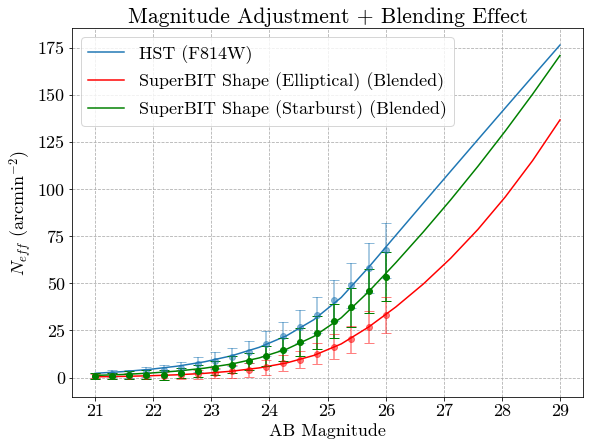

In [36]:
# Plot n_eff
plt.figure(figsize=(8,6))
alp=0.5
alp1=1


plt_mags= np.linspace(21.0, MAG_LIM+3, num=len(hst_meds)) #Extrapolation range


# Plot F814W N_eff
plt.plot(plt_mags, n_extrapolation(plt_mags, *hst_fit, f_hst), label="HST (F814W)", color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds, fmt='o', color='C0', alpha=alp)

# plt.plot(plt_mags, n_extrapolation(plt_mags, *sbit_fit, f_superbit_f814w), label="SuperBIT F814W (Blended)", color='b')
# plt.errorbar(mags, sbit_meds, yerr=sbit_stds, fmt='o', color='b', alpha=alp)

# Plot SuperBIT Shape Band N_eff
plt.plot(plt_mags, n_extrapolation(plt_mags, *e_fit, f_superbit), label="SuperBIT Shape (Elliptical) (Blended)", color='r')
plt.errorbar(mags, sbit_e_meds, yerr=sbit_e_stds, fmt='o', color='r', alpha=alp)

plt.plot(plt_mags, n_extrapolation(plt_mags, *sb_fit, f_superbit), label="SuperBIT Shape (Starburst) (Blended)", color='g')
plt.errorbar(mags[:len(mags)-sb_lim], sbit_sb_meds[:len(sbit_sb_meds)-sb_lim], yerr=sbit_sb_stds[:len(sbit_sb_stds)-sb_lim], fmt='o', color='g', alpha=1)

# plt.plot(plt_mags, n_extrapolation(plt_mags, *mixed_fit, f_superbit), label="SuperBIT Shape (Blended)", color='k')
# plt.errorbar(mags, sbit_mixed_meds, yerr=sbit_mixed_stds, fmt='o', color='k', alpha=alp)

plt.title("Magnitude Adjustment + Blending Effect")
plt.xlabel("AB Magnitude")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
plt.grid(linestyle='--')

# plt.xlim(21.1, 29)
# plt.ylim(37.5, 38.5)

# plt.savefig(DIRECTORY+'blending+magnitude_neff_hst_superbit_split_extrapolated.png', bbox_inches='tight')

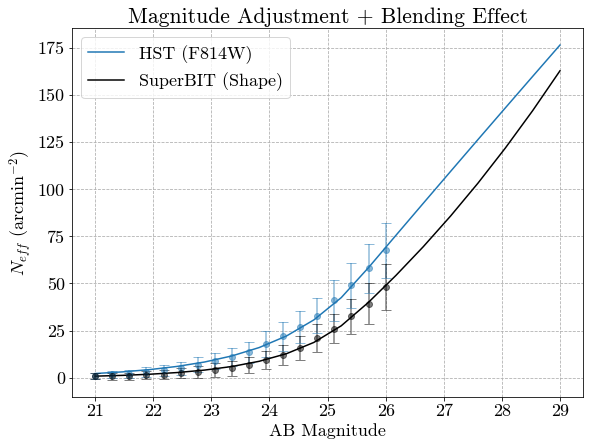

In [41]:
# Plot n_eff
plt.figure(figsize=(8,6))
alp=0.5
alp1=1


plt_mags= np.linspace(21.0, MAG_LIM+3, num=len(hst_meds)) #Extrapolation range


# Plot F814W N_eff
plt.plot(plt_mags, n_extrapolation(plt_mags, *hst_fit, f_hst), label="HST (F814W)", color='C0')
plt.errorbar(mags, hst_meds, yerr=hst_stds, fmt='o', color='C0', alpha=alp)

# plt.plot(plt_mags, n_extrapolation(plt_mags, *sbit_fit, f_superbit_f814w), label="SuperBIT F814W (Blended)", color='b')
# plt.errorbar(mags, sbit_meds, yerr=sbit_stds, fmt='o', color='b', alpha=alp)

# Plot SuperBIT Shape Band N_eff
# plt.plot(plt_mags, n_extrapolation(plt_mags, *e_fit, f_superbit), label="SuperBIT Shape (Elliptical) (Blended)", color='r')
# plt.errorbar(mags, sbit_e_meds, yerr=sbit_e_stds, fmt='o', color='r', alpha=alp)

# plt.plot(plt_mags, n_extrapolation(plt_mags, *sb_fit, f_superbit), label="SuperBIT Shape (Starburst) (Blended)", color='g')
# plt.errorbar(mags[:len(mags)-sb_lim], sbit_sb_meds[:len(sbit_sb_meds)-sb_lim], yerr=sbit_sb_stds[:len(sbit_sb_stds)-sb_lim], fmt='o', color='g', alpha=1)

plt.plot(plt_mags, n_extrapolation(plt_mags, *mixed_fit, f_superbit), label="SuperBIT (Shape)", color='k')
plt.errorbar(mags[:len(mags)-mixed_lim], sbit_mixed_meds[:len(sbit_mixed_meds)-mixed_lim], yerr=sbit_mixed_stds[:len(sbit_mixed_stds)-mixed_lim], fmt='o', color='k', alpha=alp)

plt.title("Magnitude Adjustment + Blending Effect")
plt.xlabel("AB Magnitude")
plt.ylabel('$N_{eff}$ (arcmin$^{-2}$)')
plt.legend()
plt.tight_layout(pad=0)
plt.grid(linestyle='--')

# plt.xlim(21.1, 29)
# plt.ylim(37.5, 38.5)

# plt.savefig(DIRECTORY+'blending+magnitude_neff_hst_superbit_extrapolated.png', bbox_inches='tight')

In [53]:
# Performance at HST ABmag 26
hst_26 = n_extrapolation(26, *hst_fit, f_hst)
# sb_f814w_26 = n_extrapolation(26, *sbit_fit, f_superbit_f814w)
sb_shape_26 = n_extrapolation(28.5, *mixed_fit, f_superbit)
# sb_e_26 = n_extrapolation(26, *e_fit, f_superbit)
# sb_s_26 = n_extrapolation(26, *sb_fit, f_superbit)

print(hst_26)
# print(sb_f814w_26)
print(sb_shape_26)
# print(sb_e_26)
# print(sb_s_26)

69.12436028884721
140.26156131507526


In [39]:
# Performance for HST Neff = 80
mag80 = 26.3
hst_80 = n_extrapolation(mag80, *hst_fit, f_hst)
sb_f814w_80 = n_extrapolation(mag80, *sbit_fit, f_superbit_f814w)
sb_shape_80 = n_extrapolation(mag80, *mixed_fit, f_superbit)


print(hst_80)
print(sb_f814w_80)
print(sb_shape_80)


79.97178631947372
69.95565744169926
58.16551571550931
